In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Google Drive 마운트해서 데이터셋 가져옴

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# ROOT_DIR, DATA_ROOT_DIR 설정

In [3]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT')
CLASSIFICATION_DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Classification')
CLASSIFICATION_TRAIN_DATA_ROOT_DIR = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train')

# DATA_ROOT_DIR = '/content/Dataset_BUSI_with_GT/'
# CLASSIFICATION_DATA_ROOT_DIR = '/content/Classification/'
# CLASSIFICATION_TRAIN_DATA_ROOT_DIR = '/content/Classification/train/'

In [4]:
# 혹시라도 이전에 같은 작업했던 내용이 있으면 지우고 새로할 수 있도록 해 놓은 것으로 보여짐.
import shutil

if os.path.exists(DATA_ROOT_DIR):   # '/content/Dataset_BUSI_with_GT 디렉토리가 이미 있으면
    shutil.rmtree(DATA_ROOT_DIR)    #  해당 폴더 지우기

if os.path.exists(CLASSIFICATION_DATA_ROOT_DIR): # '/content/Classification' 디렉토리가 이미 있으면
    shutil.rmtree(CLASSIFICATION_DATA_ROOT_DIR)  # 해당 폴더 지우기

# Google Drive 에서 dataset download

In [5]:
import shutil
import os

try:
    # dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    # shutil.copy(os.path.join(dataset_path, 'Dataset_BUSI_with_GT.zip'), '/content')
    shutil.copy('/content/gdrive/MyDrive/Colab Notebooks/Breast Ultrasound Images Dataset.zip', ROOT_DIR)  # /content 에 복사

except Exception as err:
    print(str(err))

In [7]:
import zipfile

# with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT.zip'), 'r') as target_file:
with zipfile.ZipFile('/content/Breast Ultrasound Images Dataset.zip', 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

### 아래 코드 실행해서 잘못된 디렉토리 구조를 바로 잡자...

In [8]:
import shutil

shutil.copytree('/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/benign', '/content/Dataset_BUSI_with_GT/benign')
shutil.copytree('/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/malignant', '/content/Dataset_BUSI_with_GT/malignant')
shutil.copytree('/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/normal', '/content/Dataset_BUSI_with_GT/normal')

shutil.rmtree('/content/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT')

In [9]:
import shutil
import os
import glob

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, '*'))

label_name_list = [ file_name.split('/')[-1].strip()  for file_name in total_file_list  if os.path.isdir(file_name) == True ]


if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)

for label_name in label_name_list:

    src_dir_path = os.path.join(DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR,
                                'train'+'/'+label_name)
    try:
        shutil.copytree(src_dir_path, dst_dir_path)
    except Exception as err:
        print(str(err))

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

train label :  benign  =>  891
train label :  malignant  =>  421
train label :  normal  =>  266


#### Classification 데이터 생성

In [13]:
import os

if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)

In [14]:
#========================================================
# copytree 이용해서 정답이름/images 디렉토리를
# train/정답이름 으로 복사함
#========================================================

for label_name in label_name_list:

    src_dir_path = os.path.join(DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train'+'/'+label_name)

    try:
        shutil.copytree(src_dir_path, dst_dir_path)
        print(label_name+' copytree is done !!')

    except Exception as err:
        print(str(err))

[Errno 17] File exists: '/content/Classification/train/benign'
[Errno 17] File exists: '/content/Classification/train/malignant'
[Errno 17] File exists: '/content/Classification/train/normal'


In [15]:
import os

#========================================================
# Classification 위한 train 정답 및 전체 데이터 개수 확인
# 현재는 image 와 mask 함께 존재하고 있음
#========================================================

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

train label :  benign  =>  891
train label :  malignant  =>  421
train label :  normal  =>  266


In [16]:
import os
import glob
import pandas as pd

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:

    temp_dic = {}

    file_list = glob.glob(CLASSIFICATION_TRAIN_DATA_ROOT_DIR+'/'+label_name+'/*')

    temp_dic[label_name] = file_list    # temp_dic['label_name'] = [ file_name, ... ]

    temp_df = pd.DataFrame(temp_dic)

    image_file_df = temp_df[~temp_df[label_name].str.contains('_mask')].reset_index(drop=True)

    mask_file_df = temp_df[temp_df[label_name].str.contains('_mask')].reset_index(drop=True)

    print('label = ', label_name, ' , image  = ', len(image_file_df), ' , mask = ', len(mask_file_df))

    for row in range(len(mask_file_df)):

        try:
            os.remove(mask_file_df.loc[row,label_name])
        except Exception as err:
            print(str(err))

label =  benign  , image  =  437  , mask =  454
label =  malignant  , image  =  210  , mask =  211
label =  normal  , image  =  133  , mask =  133


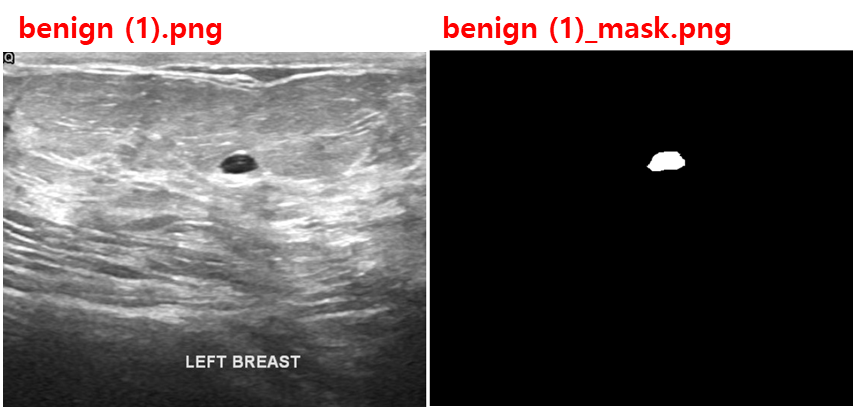

# Classification 에서 Data Augmentation 하기 위한 전체 데이터 개수 계산

In [17]:
import os

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

total_image_data_nums = 0

for label_name in train_label_name_list:    # 각각의 정답(label)에 대해서

    image_data_nums = len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name)))

    print('label = ', label_name, ' , data nums = ', image_data_nums)

    total_image_data_nums += image_data_nums

print('total image data nums = ', total_image_data_nums)

label =  benign  , data nums =  437
label =  malignant  , data nums =  210
label =  normal  , data nums =  133
total image data nums =  780


In [18]:
TOTAL_TRAIN_IMAGE_DATA_NUMS = total_image_data_nums

### Data Augmentation
모델이 적은 이미지에서 최대한 많은 정보를 뽑아내서 학습할 수 있도록 우선 이미지를 augment함.

이미지를 사용할 때마다 임의로 변형을 가함으로써 마치 훨씬 더 많은 이미지를 보고 공부하는 것과 같은 학습 효과를 낸다.

이를 통해 과적합(overfitting), 즉 모델이 학습 데이터에만 맞춰지는 것을 방지하고, 새로운 이미지도 잘 분류할 수 있게 됨.

이런 전처리 과정을 돕기 위해 케라스는 ImageDataGenerator 클래스를 제공

```
datagen = ImageDataGenerator(
        rotation_range = 40,        # 이미지 회전 범위 (degrees)
        width_shift_range = 0.2,    # 그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
        height_shift_range = 0.2,    
        rescale = 1./255,             # 원본 영상은 0-255의 RGB 계수로 구성되는데,
       이 같은 입력값은 모델을 효과적으로 학습시키기에 너무 높음 (통상적인 learning rate를 사용할 경우).
       그래서 이를 1/255로 스케일링하여 0-1 범위로 변환. 이는 다른 전처리 과정에 앞서 가장 먼저 적용.
        shear_range = 0.2,           # 임의 전단 변환 (shearing transformation) 범위
        zoom_range = 0.2,           # 임의 확대/축소 범위
        horizontal_flip = True,       # True로 설정할 경우, 50% 확률로 이미지를 수평으로 뒤집음.
        원본 이미지에 수평 비대칭성이 없을 때 효과적. 즉, 뒤집어도 자연스러울 때 사용하면 좋음.
        fill_mode = `nearest`)        # 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식
```



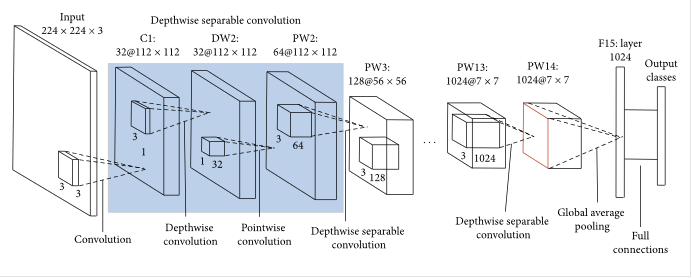

In [19]:
original_gen = ImageDataGenerator(rescale=1./255)

original_generator = original_gen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR,
                                   batch_size=TOTAL_TRAIN_IMAGE_DATA_NUMS, shuffle=False,
                                   target_size=(224, 224), class_mode='sparse')

Found 780 images belonging to 3 classes.


In [20]:
x_train, y_train = original_generator.next()

print(x_train.shape, y_train.shape)

(780, 224, 224, 3) (780,)


#### Augmentation Data 생성

In [22]:
AUGMENTATION_COUNT = 4    # 원본 데이터의 4배 증대

In [23]:
augmentation_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, shear_range=0.1, zoom_range=0.1,
                                      horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

augmentation_generator = augmentation_gen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR,
                                   batch_size=TOTAL_TRAIN_IMAGE_DATA_NUMS, shuffle=False,
                                   target_size=(224, 224), class_mode='sparse')

Found 780 images belonging to 3 classes.


In [24]:
import numpy as np

print('====================================================')
print('[bofore] ', x_train.shape, y_train.shape)
print('====================================================')

for i in range(AUGMENTATION_COUNT):    # 780개의 전체 데이터에 대해서 AUGMENTATION_COUNT 배 AUGMENTATION 실행

    x_augmented, y_augmented = augmentation_generator.next()

    x_train = np.concatenate( (x_train, x_augmented) )
    y_train = np.concatenate( (y_train, y_augmented) )

print('[after] ', x_train.shape, y_train.shape)
print('====================================================')

[bofore]  (780, 224, 224, 3) (780,)
[after]  (3900, 224, 224, 3) (3900,)


# train data random shuffle

In [25]:
s = np.arange(x_train.shape[0])

np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]

In [26]:
SPLIT_RATIO = 0.2    # train : test = 8 : 2

### 검증(테스트) 데이터 분리(20%)

In [29]:
split_num = int(SPLIT_RATIO*(x_train.shape[0]))

x_test = x_train[:split_num]

y_test = y_train[:split_num]

print(x_test.shape, y_test.shape)

(624, 224, 224, 3) (624,)


### 훈련 데이터 분리(80%)

In [30]:
x_train = x_train[split_num:]

y_train = y_train[split_num:]

print(x_train.shape, y_train.shape)

(2496, 224, 224, 3) (2496,)


# 16 개의 데이터와 정답 출력

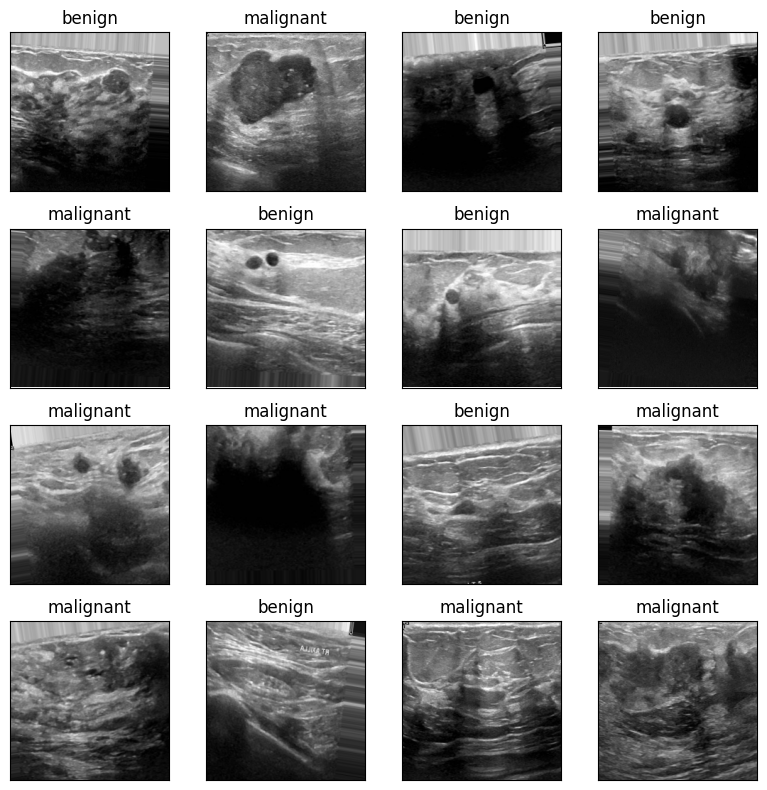

In [31]:
import matplotlib.pyplot as plt

class_dict = {0:'benign', 1:'malignant', 2:'normal'}

plt.figure(figsize=(8,8))

for i in range(16):

    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[int(y_train[i])]))
    plt.xticks([])
    plt.yticks([])

    plt.imshow(x_train[i])

plt.tight_layout()
plt.show()

# IMAGE SHAPE 설정

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

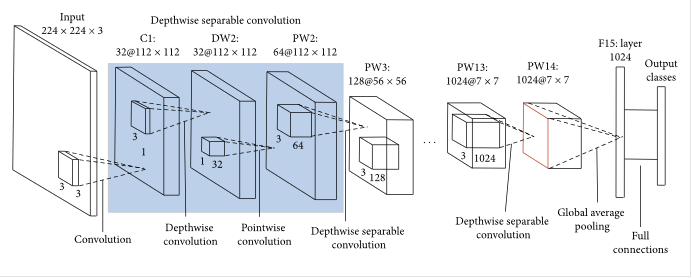

In [ ]:
class_nums = original_generator.num_classes

pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))                                # Drop out? 뭐하는 짓일까??? 효과 ???
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

In [ ]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
98/98 [==============================] - 26s 204ms/step - loss: 1.2994 - acc: 0.4625 - val_loss: 0.8606 - val_acc: 0.6038
Epoch 2/50
98/98 [==============================] - 19s 189ms/step - loss: 1.0076 - acc: 0.5622 - val_loss: 0.7892 - val_acc: 0.6538
Epoch 3/50
98/98 [==============================] - 19s 191ms/step - loss: 0.8259 - acc: 0.6295 - val_loss: 0.6975 - val_acc: 0.6962
Epoch 4/50
98/98 [==============================] - 19s 191ms/step - loss: 0.7006 - acc: 0.6952 - val_loss: 0.6008 - val_acc: 0.7564
Epoch 5/50
98/98 [==============================] - 19s 192ms/step - loss: 0.5860 - acc: 0.7548 - val_loss: 0.4945 - val_acc: 0.8038
Epoch 6/50
98/98 [==============================] - 19s 192ms/step - loss: 0.5317 - acc: 0.7875 - val_loss: 0.4345 - val_acc: 0.8359
Epoch 7/50
98/98 [==============================] - 19s 194ms/step - loss: 0.4506 - acc: 0.8179 - val_loss: 0.3764 - val_acc: 0.8641
Epoch 8/50
98/98 [==============================] - 19s 193ms/step - 

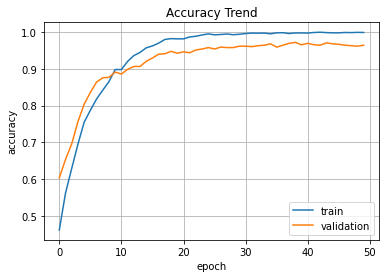

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

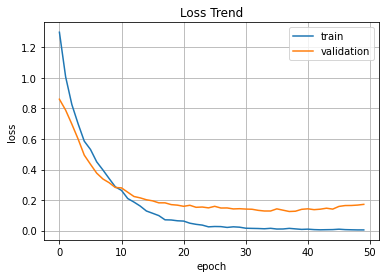

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 1s 38ms/step - loss: 0.1720 - acc: 0.9641


[0.17196087539196014, 0.964102566242218]